In [201]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = '4c635c9b66b0ab2f37ce29d7bc33edc66f815847092ba236aa79748304b2cd4bbba6c35d8a4a6adc9b579b1990cfa8066f5220cbdc29044dc9bd59f1c1e1ea1b'
instance = 'ibm-q/open/main'

service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance=instance,
        token=token
)

# Save your IBM Quantum API key in
# ~/.qiskit/qiskit-ibm.json
service.save_account(channel="ibm_quantum", 
                                  token=token,
                                  overwrite=True)

## Define the Quantum Circuit (qc)

In [203]:
from qiskit import QuantumCircuit, ClassicalRegister

# Creates a GHZ state with the specified number of qubits
# should generate 2 states: (0)n + (1)n for n qubits
#  e.g. n = 4, 0000 + 1111
def create_quantum_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # Apply Hadamard gate to each qubit
    for i in range(num_qubits):
        qc.h(i)
    # Apply CNOT gate between each pair of qubits
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    # Add classical registers and measurements
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

# Specify the number of qubits
num_qubits = 3  # Change this value as needed
qc = create_quantum_circuit(num_qubits)

print(qc)

      ┌───┐          ┌─┐      
 q_0: ┤ H ├──■───────┤M├──────
      ├───┤┌─┴─┐     └╥┘┌─┐   
 q_1: ┤ H ├┤ X ├──■───╫─┤M├───
      ├───┤└───┘┌─┴─┐ ║ └╥┘┌─┐
 q_2: ┤ H ├─────┤ X ├─╫──╫─┤M├
      └───┘     └───┘ ║  ║ └╥┘
c8: 3/════════════════╩══╩══╩═
                      0  1  2 


### Print out the IBM Quantum details: instances and backends 
- to be used for Testing quality of backends at different qubit sizes

In [204]:
print(service.instances())
print(service.backends())

print(f"backend_names = {[backend.name for backend in service.backends()]}")

['ibm-q/open/main']


[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>]
backend_names = ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_kyiv']


## Run the program across the QuantumCircuit(qc) and Backends defined above
- uses the service() account logged into at the top with the given token
- token should be saved in ~/.qiskit/

In [207]:
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# List of backend names
backend_names = ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_kyiv']  # Replace with current list of backends

def run_program(backend_name, qc):
    try:
        # Get the backendsimulator = Aer.get_backend('statevector_simulator')

        backend = service.backend(backend_name)
        # Set up pass_manager for backend
        pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

        # Run pass_manager through transpiler
        qc_transpiled = pass_manager.run(qc)

        # Run the Sampler job
        sampler = Sampler(mode=backend)
        job = sampler.run(pubs=[qc_transpiled])
        
        return job.job_id()
    
    except Exception as e:
        print(f"Error running program on backend {backend_name}: {e}")
        return None

# Run the jobs on the backends and capture job_id and backend_name
jobs_backend = []
for backend_name in backend_names:
    print(f"Submitting to: {backend_name}")
    job_id = run_program(backend_name, qc)
    if job_id:
        jobs_backend.append((job_id, backend_name))
        print(f"Job ID: {job_id}")
    else:
        print(f"Failed to submit job to {backend_name}")

print(f"jobs_backend = {jobs_backend}")

Submitting to: ibm_brisbane


Job ID: cxz1qs7wk6yg008j7jx0
Submitting to: ibm_sherbrooke
Job ID: cxz1qtzwk6yg008j7jy0
Submitting to: ibm_kyiv
Job ID: cxz1qx74a290008y4nf0
jobs_backend = [('cxz1qs7wk6yg008j7jx0', 'ibm_brisbane'), ('cxz1qtzwk6yg008j7jy0', 'ibm_sherbrooke'), ('cxz1qx74a290008y4nf0', 'ibm_kyiv')]


### When programs are finished, call the job_ids and compare results

In [215]:
# 3-bit circuit, GHZ state
jobs_backend = [('cxz1qs7wk6yg008j7jx0', 'ibm_brisbane'), ('cxz1qtzwk6yg008j7jy0', 'ibm_sherbrooke'), ('cxz1qx74a290008y4nf0', 'ibm_kyiv')]

# quick peak
for job_id, backend_name in jobs_backend:
    print(f"{backend_name}:\n\t{job_id} - {job.status()}")
    #if backend_name == 'ibm_brisbane':  # skip this one
    #    continue
    result = service.job(job_id).result()[0] 
    print(result)
    print(f"{result.data.c8.get_counts()}")  # corrected access to data attribute

ibm_brisbane:
	cxz1qs7wk6yg008j7jx0 - DONE
ibm_sherbrooke:
	cxz1qtzwk6yg008j7jy0 - DONE
SamplerPubResult(data=DataBin(c8=BitArray(<shape=(), num_shots=4096, num_bits=3>)), metadata={'circuit_metadata': {}})
{'000': 553, '101': 468, '010': 506, '110': 502, '100': 485, '001': 567, '011': 516, '111': 499}
ibm_kyiv:
	cxz1qx74a290008y4nf0 - DONE
SamplerPubResult(data=DataBin(c8=BitArray(<shape=(), num_shots=4096, num_bits=3>)), metadata={'circuit_metadata': {}})
{'101': 552, '001': 488, '000': 526, '110': 499, '111': 525, '011': 505, '010': 502, '100': 499}


### Get results for all backends and normalize

     ibm_sherbrooke  ibm_kyiv
000        0.135010  0.128418
101        0.114258  0.134766
010        0.123535  0.122559
110        0.122559  0.121826
100        0.118408  0.121826
001        0.138428  0.119141
011        0.125977  0.123291
111        0.121826  0.128174


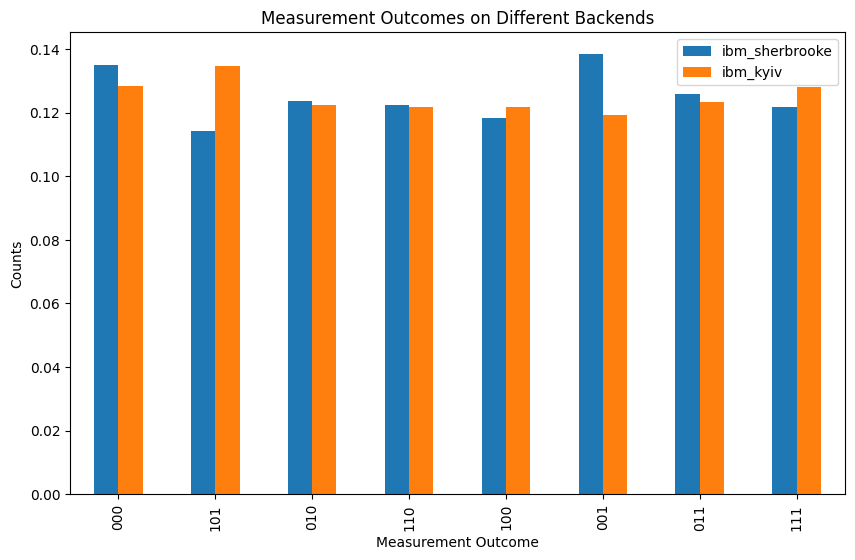

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.quantum_info import state_fidelity, Statevector
import time

# Normalize counts to probabilities
def normalize_counts(counts):
    total = sum(counts.values())
    return {key: val / total for key, val in counts.items()}

# Function to check job status and retrieve results
def get_job_result(job_id):
    try:
        job = service.job(job_id)
        while job.status() not in ['DONE', 'CANCELLED', 'ERROR']:
            print(f"Job {job_id} status: {job.status()}")
            time.sleep(10)  # Wait for 10 seconds before checking the status again
        if job.status() == 'DONE':
            result = job.result()
            counts = result[0].data.c8.get_counts()
            normalized_counts = normalize_counts(counts)
            return normalized_counts
        else:
            print(f"Job {job_id} failed with status: {job.status()}")
            return None
    except Exception as e:
        print(f"Error retrieving result for job {job_id}: {e}")
        return None

# Retrieve the results
results = {}
for job_id, backend_name in jobs_backend:
    #if backend_name == 'ibm_brisbane':  # skip this one
    #    continue
    counts = get_job_result(job_id)
    if counts:
        results[backend_name] = counts

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Display the results as a table
print(df)

# Plot the results
df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('Measurement Outcomes on Different Backends')
plt.show()

# Calculate and display fidelity between the results of different backends
ideal_backend = backend_names[0]
ideal_counts = results.get(ideal_backend)


### Print out the GHZ fidelity for each result
- ideally = 1.00

In [217]:
def ghz_fidelity(experimental_counts, num_qubits):
    ideal_bitstrings = ['0' * num_qubits, '1' * num_qubits]
    experimental_probs = normalize_counts(experimental_counts)
    fidelity = sum(experimental_probs.get(bitstring, 0) for bitstring in ideal_bitstrings)
    return fidelity

# Print out fidelity of each reult
for backend_name, counts in results.items():
    fidelity = ghz_fidelity(counts, num_qubits)
    print(f"Fidelity with ideal state for {backend_name}: {fidelity:.2f}") 

Fidelity with ideal state for ibm_sherbrooke: 0.26
Fidelity with ideal state for ibm_kyiv: 0.26
